In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
%matplotlib inline
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
from sklearn.neighbors import KNeighborsRegressor

In [3]:
def _plot_cm(y_true, y_pred, ax, ax_labels, title):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm / cm.sum(axis=1, keepdims=True)
    im = ax.imshow(cm, cmap='cubehelix', vmin=0, vmax=1)
    plt.xticks(range(len(ax_labels)), ax_labels)
    plt.yticks(range(len(ax_labels)), ax_labels)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Real')
    ax.set_title(title)
    return im

def plot_cm(y_true, y_pred, y_shuffle_true, y_shuffle_pred):
    '''
    plot confusion matrix

    Args:
        y_true ([np.array]): array for true label
        y_pred ([np.array]): array for predicted label
        y_shuffle_true ([np.array]): array for shffuled label
        y_shuffle_pred ([np.array]): array for shuffled predicted label
    '''
    fig = plt.figure(figsize=(23, 10), facecolor='white')
    gs = GridSpec(ncols=3, nrows=1, wspace=0.1, figure = fig, width_ratios=[10,10,0.3])
    fig_ax = fig.add_subplot(gs[0,0])
    labels = np.unique(y_true)
    _plot_cm(y_true, y_pred, fig_ax, labels, f'Real Accuracy {accuracy_score(y_true, y_pred):0.2f}')

    fig_ax = fig.add_subplot(gs[0,1])
    im = _plot_cm(y_shuffle_true, y_shuffle_pred, fig_ax, labels, f'Shuffle Accuracy {accuracy_score(y_shuffle_true, y_shuffle_pred):0.2f}')
    fig_ax.set_ylabel('')
    fig_ax.set_yticklabels([])

    # plot colorbar
    cb = fig.add_subplot(gs[0,2])
    fig.colorbar(mappable=im, cax=cb, label='Fraction of labels', )
    fig.tight_layout()
    plt.show()
    c = PlotConfig()
    #fig.savefig(c.dana_save_path / "age_vs_behavioral_age"/ 'age_decoder_confusion_pre.pdf')

In [4]:
format_plots()
#format_pizza_plots()

In [5]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [6]:
## update data
def filter_df(df):
    max=49
    #df.drop('9c060c9b-9eee-4788-90be-803700bbacd8',level=3, axis=0, inplace=True)
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [7]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/dana_ontogeny_males_relabeled_usage_matrix_v00.parquet')
df_dana = pd.read_parquet(path)

path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)

In [8]:
# arrange data
data = df.astype(float, errors='ignore')
data= filter_df(data).groupby(['age','uuid']).mean()
data['data'] = 'min'
data.set_index('data', inplace=True, append=True)

data_dana = df_dana.astype(float, errors='ignore')
data_dana= filter_df(data_dana).groupby(['age','uuid']).mean()
data_dana['data'] = 'dana'
data_dana.set_index('data', inplace=True, append=True)

data_all = pd.concat([data,data_dana])

In [9]:
# filter data to make sure only ages from both dataset appear in subsequent analysis
mask = data.index.get_level_values('age').intersection(data_dana.index.get_level_values('age'))
fdata = data[data.index.get_level_values('age').isin(mask)]

fdata_dana = data_dana[data_dana.index.get_level_values('age').isin(mask)]
fdata_all = pd.concat([fdata,fdata_dana])

data=fdata_all.copy()

In [10]:
data


46        5         11  \
age uuid                                 data                                 
12  00e06314-990c-41ca-8373-d0ae52c0c64a min   0.007690  0.012304  0.007998   
    0db7e760-1f0c-427e-80cc-eb54fe9c1e1c min   0.002446  0.012229  0.013757   
    1e61fc30-95e2-4e01-9fe0-6e173237eb2e min   0.006433  0.021086  0.015368   
    3dfccca3-d4a6-45cf-8b10-b1ccab35a562 min   0.002334  0.037059  0.020134   
    3ee7c135-0ec6-46db-80fc-1166a104e7a9 min   0.005443  0.033301  0.028818   
...                                                 ...       ...       ...   
90  b365ea6a-369f-4991-b139-15694dc1c86d dana  0.001217  0.023737  0.008217   
    b7b7dfa0-66e1-4f48-a118-2fec4b8ce144 dana  0.006017  0.001504  0.023693   
    b878ffa4-ab8b-42bb-821a-f8bb23af1959 dana  0.012791  0.024031  0.056202   
    e272b7f4-3fe2-4fba-8ae9-0b1f8da43f69 dana  0.007459  0.010531  0.005265   
    fffeff2c-94ab-42aa-ab9a-420a58e32679 dana  0.006221  0.005054  0.021773   

                                                     0         3         12  \
age uuid                                 data                                 
12  00e06314-990c-41ca-8373-d0ae52c0c64a min   0.037219  0.039373  0.030145   
    0db7e760-1f0c-427e-80cc-eb54fe9c1e1c min   0.031183  0.026292  0.036075   
    1e61fc30-95e2-4e01-9fe0-6e173237eb2e min   0.050393  0.055754  0.019299   
    3dfccca3-d4a6-45cf-8b10-b1ccab35a562 min   0.039101  0.054567  0.031223   
    3ee7c135-0ec6-46db-80fc-1166a104e7a9 min   0.016010  0.034582  0.021774   
...                                                 ...       ...       ...   
90  b365ea6a-369f-4991-b139-15694dc1c86d dana  0.085210  0.072124  0.011869   
    b7b7dfa0-66e1-4f48-a118-2fec4b8ce144 dana  0.146672  0.054156  0.019556   
    b878ffa4-ab8b-42bb-821a-f8bb23af1959 dana  0.086434  0.039922  0.008140   
    e272b7f4-3fe2-4fba-8ae9-0b1f8da43f69 dana  0.157086  0.064063  0.004388   
    fffeff2c-94ab-42aa-ab9a-420a58e32679 dana  0.113142  0.061431  0.012830   

                                                     20        32        13  \
age uuid                                 data                                 
12  00e06314-990c-41ca-8373-d0ae52c0c64a min   0.025223  0.004614  0.011381   
    0db7e760-1f0c-427e-80cc-eb54fe9c1e1c min   0.049832  0.013757  0.012229   
    1e61fc30-95e2-4e01-9fe0-6e173237eb2e min   0.015011  0.012152  0.018227   
    3dfccca3-d4a6-45cf-8b10-b1ccab35a562 min   0.028596  0.006711  0.014590   
    3ee7c135-0ec6-46db-80fc-1166a104e7a9 min   0.029459  0.009926  0.017931   
...                                                 ...       ...       ...   
90  b365ea6a-369f-4991-b139-15694dc1c86d dana  0.004260  0.005478  0.021911   
    b7b7dfa0-66e1-4f48-a118-2fec4b8ce144 dana  0.000752  0.001128  0.013539   
    b878ffa4-ab8b-42bb-821a-f8bb23af1959 dana  0.005039  0.001938  0.023256   
    e272b7f4-3fe2-4fba-8ae9-0b1f8da43f69 dana  0.001316  0.000878  0.013602   
    fffeff2c-94ab-42aa-ab9a-420a58e32679 dana  0.000000  0.001944  0.026439   

                                                     4   ...        10  \
age uuid                                 data            ...             
12  00e06314-990c-41ca-8373-d0ae52c0c64a min   0.012919  ...  0.017225   
    0db7e760-1f0c-427e-80cc-eb54fe9c1e1c min   0.007949  ...  0.010700   
    1e61fc30-95e2-4e01-9fe0-6e173237eb2e min   0.032881  ...  0.016440   
    3dfccca3-d4a6-45cf-8b10-b1ccab35a562 min   0.036475  ...  0.017508   
    3ee7c135-0ec6-46db-80fc-1166a104e7a9 min   0.019853  ...  0.009286   
...                                                 ...  ...       ...   
90  b365ea6a-369f-4991-b139-15694dc1c86d dana  0.014607  ...  0.033171   
    b7b7dfa0-66e1-4f48-a118-2fec4b8ce144 dana  0.028206  ...  0.064686   
    b878ffa4-ab8b-42bb-821a-f8bb23af1959 dana  0.041473  ...  0.021705   
    e272b7f4-3fe2-4fba-8ae9-0b1f8da43f69 dana  0.014480  ...  0.124177   
    fffeff2c-94ab-42aa-ab9a-420a58e32679 dana  0.049767  ...  0.068429   

      

In [11]:
# choose a model for decoder
# choose a model for decoder
#clf = svm.SVC(kernel='linear') 
clf = RandomForestClassifier(n_estimators = 150)
#clf = LinearRegression()
#clf = KNeighborsRegressor(n_neighbors=10)

# choose cross validation scheme
cv = LeaveOneOut()
#cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
#cv=5

#number of iterations for shuffle
it=10

In [12]:
sh_ages=[]
age2=[]
acc=[]
sh_acc=[]
for age,_df in enumerate(data.groupby('age')):
    #ages.extend(_df[1].index.get_level_values('remapped_bins').to_numpy())
    age2.append(_df[0])
    x = _df[1].to_numpy()
    #x = np.log(x + 1e-6)
    y=_df[1].index.get_level_values('data')
    y_pred = cross_val_predict(clf, x, y, cv=cv)
    acc.append(np.mean(cross_val_score(clf, x, y, cv=cv)))
    for i in tqdm(range(it)):
        sh_ages.append(_df[0])
        ysh_temp=np.random.permutation(y)
        sh_acc.append(np.mean(cross_val_score(clf, x, ysh_temp, cv=cv)))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:14<00:00,  7.47s/it]


In [13]:
# create df for plotting
df_sh = pd.DataFrame()
df_sh['acc']=sh_acc
df_sh['ages'] = sh_ages

df = pd.DataFrame()
df['acc']=acc
df['ages'] = age2

(array([  0.,  20.,  40.,  60.,  80., 100.]),
 [Text(0.0, 0, '0'),
  Text(20.0, 0, '20'),
  Text(40.0, 0, '40'),
  Text(60.0, 0, '60'),
  Text(80.0, 0, '80'),
  Text(100.0, 0, '100')])

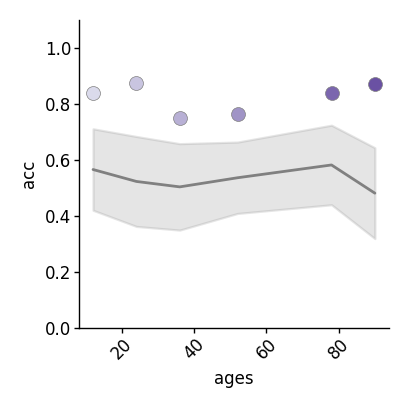

In [14]:
fig, ax = plt.subplots(figsize=(2, 2))
#sns.violinplot(data=df_sh, x="ages", y="acc", ax=ax, color='gray')
sns.lineplot(data=df_sh, x="ages", y="acc", ax=ax, color='gray', estimator='mean', errorbar=('sd', 2))
#sns.pointplot(data=df, x="ages", y="acc",
              #xticklabels=1,
              #dodge=0, 
#              join=False, 
#              ax=ax, 
#              scale=1,
#              hue='ages',
 #             palette='Blues',
              #edgecolor='gray',
              #linewidth=0.3
 #            )
#sns.lineplot(data=df, x="ages", y="acc", ax=ax, color='gray')
sns.lineplot (data=df, x='ages', y='acc', 
              markers=True, 
              marker='o',
              markersize=5,
              palette = cmm,
              hue='ages',
              linestyle='-',
              markeredgecolor='grey', 
              markeredgewidth=0.25,
             legend=False)
plt.ylim([0.0,1.1])
plt.legend([],[], frameon=False)
sns.despine()
plt.xticks(rotation=45)
